In [34]:
import os, glob
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from imp import reload

from noise_correlations.data import datasets
from noise_correlations import discriminability, null_models
from noise_correlations.discriminability import lfi_data, lda_data, corrected_lfi_data, mv_normal_jeffreys_data
from noise_correlations.null_models import random_rotation_data, shuffle_data
from noise_correlations import plot

from noise_correlations import analysis

In [35]:
# data paths
folder = 'kohn_pvc-11/'
reload(datasets)
ds = datasets.KohnCRCNSpvc11_monkey(folder)
Yp = ds.data_tensor()
trial_median = np.median(Yp, axis=-1)
keep = np.logical_and(trial_median.max(axis=-1) >= 10,
                      trial_median.max(axis=-1) >= 2.0 * trial_median.min(axis=-1))
Yo = Yp
Yp = Yp[keep]
bas = np.median(Yp, axis=-1).argmax(axis=1)
idxs = np.argsort(bas)
Yp = Yp[idxs]
bas = bas[idxs]
n_neurons, n_stimuli, n_trials = Yp.shape
print(n_neurons)

44


In [36]:
cs = []
for ii in range(12):
    

(44, 12, 200)

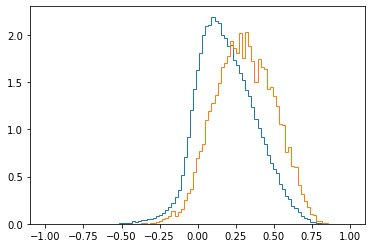

In [33]:
bins = np.linspace(-1, 1, 100)
plt.hist(analysis.all_correlations(Yo), bins=bins, density=True, histtype='step')
_ = plt.hist(analysis.all_correlations(Yp), bins=bins, density=True, histtype='step')


In [22]:
reload(analysis)
p_s_lfi, p_s_sdkl, p_r_lfi, p_r_sdkl, v_lfi, v_sdkl = analysis.compare_nulls_measures(Yp, 4, 1000,
                                                                                      np.random, 100, circular_stim=True)

Bbox(x0=0.125, y0=0.125, x1=0.9, y1=0.88)


(<Figure size 360x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0996f4aac8>)

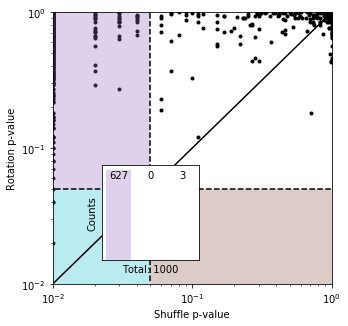

In [23]:
reload(plot)
plot.plot_pvalue_comparison(p_s_lfi, p_r_lfi, labels=['Shuffle p-value', 'Rotation p-value'])

Bbox(x0=0.125, y0=0.125, x1=0.9, y1=0.88)


(<Figure size 360x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0996b46da0>)

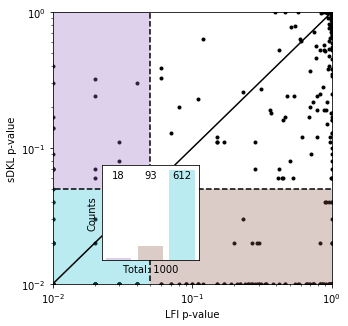

In [25]:
reload(plot)
plot.plot_pvalue_comparison(p_s_lfi, p_s_sdkl, labels=['LFI p-value', 'sDKL p-value'])

Bbox(x0=0.125, y0=0.125, x1=0.9, y1=0.88)


(<Figure size 360x360 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0996a50208>)

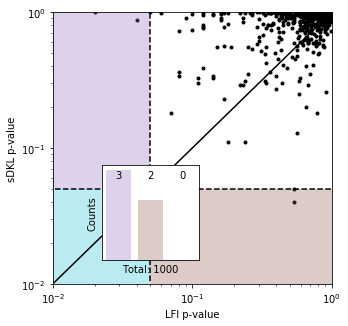

In [26]:
reload(plot)
plot.plot_pvalue_comparison(p_r_lfi, p_r_sdkl, labels=['LFI p-value', 'sDKL p-value'])

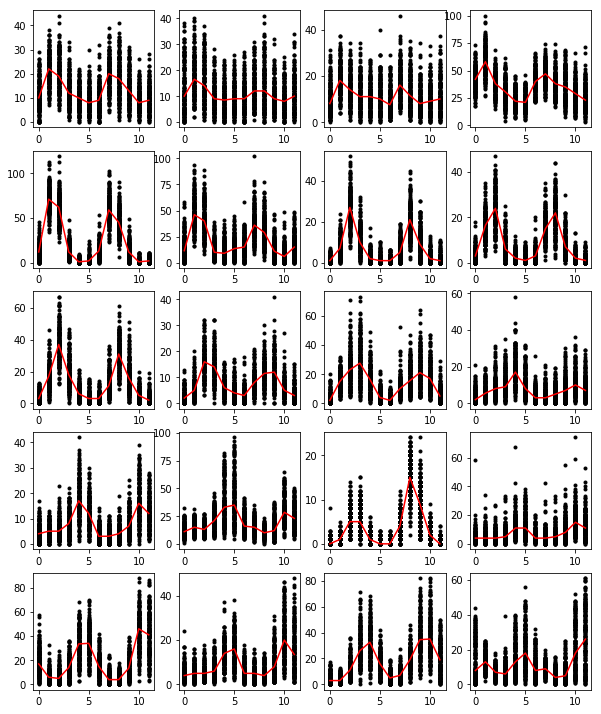

In [9]:
fig, axes = plt.subplots(Yp.shape[0]//4, 4, figsize=(10, 12.5))
for ax_idx, ax in enumerate(axes.ravel()):
    counts = Yp[ax_idx]
    angles = np.tile(np.arange(n_stimuli)[:, np.newaxis], (1, Yp.shape[-1]))
    ax.scatter(angles, counts, marker='.', color='k')
    ax.plot(np.median(angles, axis=1), np.median(counts, axis=1), color='r')

In [3]:
delta_as = 2
delta_ns = 2
n_boot = 10000

n_pts = 0
for ii in range(n_neurons):
    for d in range(delta_ns):
        n0 = ii
        n1 = (ii + d + 1) % n_neurons
        mina = bas[n0] - delta_as
        maxa = bas[n1] + delta_as + 1
        if maxa < mina:
            maxa += n_stimuli
        n_pts += maxa - mina
print(n_pts)

ps = np.full((2, 2, n_pts), np.nan)
idx = 0
for ii in range(n_neurons):
    print(float(idx) / n_pts)
    for d in range(delta_ns):
        n0 = ii
        n1 = (ii + d + 1) % n_neurons
        mina = bas[n0] - delta_as
        maxa = bas[n1] + delta_as + 1
        if maxa < mina:
            maxa += n_stimuli
        for a in range(mina, maxa):
            a0 = a % n_stimuli
            a1 = (a + 1) % n_stimuli
            x = Yp[[n0, n1]][:, a0].T
            y = Yp[[n0, n1]][:, a1].T
            val_s, values_s, ps_s = null_models.eval_null_data(x, y, shuffle_data,
                                                               [lfi_data, mv_normal_jeffreys_data], n_boot)
            val_r, values_r, ps_r = null_models.eval_null_data(x, y, random_rotation_data,
                                                               [lfi_data, mv_normal_jeffreys_data], n_boot, same_null=True)
            ps[0, :, idx] = ps_s
            ps[1, :, idx] = ps_r
            idx += 1

236
0.0
0.0423728813559322
0.0847457627118644
0.1271186440677966
0.1694915254237288
0.21610169491525424
0.2669491525423729
0.3093220338983051
0.3516949152542373
0.3983050847457627
0.4533898305084746
0.5042372881355932
0.5508474576271186
0.614406779661017
0.690677966101695
0.75
0.7923728813559322
0.8347457627118644
0.8813559322033898
0.940677966101695


In [4]:
np.savez('ps_kohn_pvc-11', ps=ps)

In [6]:
rng = np.random.RandomState(20190221)

n_pts = 1000
n_boot = 10000

R1s = []
R2s = []
for nn in range(n_boot):
    angle = 2. * np.pi * rng.rand()
    R = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    R1s.append(R)
    angle = 2. * np.pi * rng.rand()
    R = np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])
    R2s.append(R)

df = np.full(n_pts, np.nan)
ps = np.full((2, 2, n_pts), np.nan)
idx = 0
for ii in range(n_pts):
    print(float(ii) / n_pts)
    es = rng.permutation(Yp.shape[0])[:2]
    angs = rng.permutation(Yp.shape[1])[:2]
    mina = angs.min()
    maxa = angs.max()
    df[ii] = min(maxa - mina, mina + n_stimuli - maxa)
    x = Yp[es][:, angs[0]].T
    y = Yp[es][:, angs[1]].T
    o_val, values_s, ps_s = null_models.eval_null_data(x, y, shuffle_data,
                                                       [lfi_data, mv_normal_jeffreys_data], n_boot)
    all_vals = np.zeros((2, n_boot))
    for jj in range(n_boot):
        r = R1s[jj]
        mux = x.mean(axis=0, keepdims=True)
        xp = (x - mux).dot(r.T) + mux
        muy = y.mean(axis=0, keepdims=True)
        yp = (y - muy).dot(r.T) + muy
        all_vals[0, jj] = lfi_data(xp, yp)
        r = R2s[jj]
        muy = y.mean(axis=0, keepdims=True)
        yp = (y - muy).dot(r.T) + muy
        all_vals[1, jj] = mv_normal_jeffreys_data(xp, yp)
    all_vals = np.concatenate([all_vals, o_val[:, np.newaxis]], axis=1)
    ps[0, :, ii] = ps_s
    ps[1, :, ii] = (all_vals >= o_val[:, np.newaxis]).mean(axis=1)

np.savez('ps2_kohn_pvc-11', ps=ps, df=df)

0.0
0.001
0.002
0.003
0.004
0.005
0.006
0.007
0.008
0.009
0.01
0.011
0.012
0.013
0.014
0.015
0.016
0.017
0.018
0.019
0.02
0.021
0.022
0.023
0.024
0.025
0.026
0.027
0.028
0.029
0.03
0.031
0.032
0.033
0.034
0.035
0.036
0.037
0.038
0.039
0.04
0.041
0.042
0.043
0.044
0.045
0.046
0.047
0.048
0.049
0.05
0.051
0.052
0.053
0.054
0.055
0.056
0.057
0.058
0.059
0.06
0.061
0.062
0.063
0.064
0.065
0.066
0.067
0.068
0.069
0.07
0.071
0.072
0.073
0.074
0.075
0.076
0.077
0.078
0.079
0.08
0.081
0.082
0.083
0.084
0.085
0.086
0.087
0.088
0.089
0.09
0.091
0.092
0.093
0.094
0.095
0.096
0.097
0.098
0.099
0.1
0.101
0.102
0.103
0.104
0.105
0.106
0.107
0.108
0.109
0.11
0.111
0.112
0.113
0.114
0.115
0.116
0.117
0.118
0.119
0.12
0.121
0.122
0.123
0.124
0.125
0.126
0.127
0.128
0.129
0.13
0.131
0.132
0.133
0.134
0.135
0.136
0.137
0.138
0.139
0.14
0.141
0.142
0.143
0.144
0.145
0.146
0.147
0.148
0.149
0.15
0.151
0.152
0.153
0.154
0.155
0.156
0.157
0.158
0.159
0.16
0.161
0.162
0.163
0.164
0.165
0.166
0.167
0.168
0.169

Bbox(x0=0.125, y0=0.125, x1=0.47727272727272724, y1=0.88)
sig shuffle:  0.3898305084745763
sig rotate:  0.012711864406779662
only sig shuffle:  0.3771186440677966
only sig rotate:  0.0
sig both:  0.012711864406779662

sig shuffle:  0.0
sig rotate:  0.0
only sig shuffle:  0.0
only sig rotate:  0.0
sig both:  0.0



/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less_equal
  del sys.path[0]
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in less_equal
  
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in less_equal
  from ipykernel import kernelapp as app
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in less_equal
  app.launch_new_instance()
/home/jesse/anaconda3/envs/noise_correlations/lib/python3.7/site-packages/ipykernel_launcher

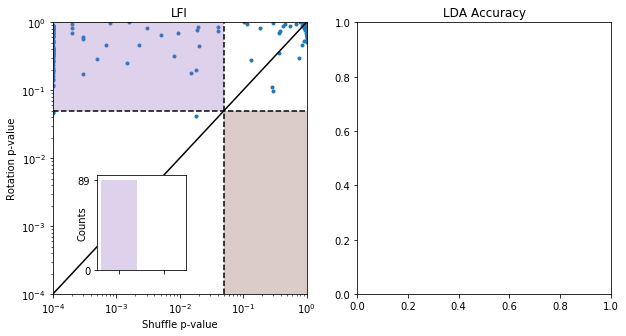

In [6]:
reload(plot)
faxes = plt.subplots(1, 2, figsize=(10, 5))
f, (ax0, ax1) = faxes
plot.plot_pvalue_comparison(ps[0, 0].ravel(), ps[1, 0].ravel(),
                       labels=['Shuffle p-value', 'Rotation p-value'], faxes=(f, ax0))
#plot.plot_pvalue_comparison(ps[0, 1].ravel(), ps[1, 1].ravel(),
#                       labels=['Shuffle p-value', 'Rotation p-value'], faxes=(f, ax1))
ax0.set_title('LFI')
ax1.set_title('LDA Accuracy')
#plt.savefig('/home/jesse/Downloads/blanche_ps.pdf')

for ii in range(2):
    print('sig shuffle: ', (ps[0, ii] <= .05).sum() / ps[0, ii].size)
    print('sig rotate: ', (ps[1, ii] <= .05).sum() / ps[1, ii].size)
    print('only sig shuffle: ', (np.logical_and(ps[0, ii] <= .05, ps[1, ii] > .05)).sum() / ps[0, ii].size)
    print('only sig rotate: ', (np.logical_and(ps[1, ii] <= .05, ps[0, ii] > .05)).sum() / ps[0, ii].size)
    print('sig both: ', (np.logical_and(ps[0, ii] <= .05, ps[1, ii] <= .05)).sum() / ps[0, ii].size)
    print()